<a href="https://colab.research.google.com/github/iPrinka/MITx-Micromasters-Statistics-Data-Science/blob/main/one_league_cnn_intro_pytorch_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Datasets and Convnets in `pytorch`

- Build model on `.csv` dataset for binary classification
- Build Convolutional Network Architecture with `pytorch`
- Build in Regularization with L2 Norm and Dropout

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

import torch
from torch import optim
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import torch.nn as nn 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier, LogisticRegression

In [ ]:
#mounting the drive
!ls

#### Problem: Classifying Diabetes Incidence

Using your classification knowledge, build and train at least 3 different classification models, and compare their performance.  For your third model, try to use `pytorch` to build and train a simple network.  

In [4]:
#loading csv with pandas
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/diabetes.csv')

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
X = df.drop(columns="Outcome")
y = df["Outcome"]

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [27]:
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
model_logreg.fit(X_train, y_train)
print(f"Training Score: {model_logreg.score(X_train, y_train)}")
print(f"Testing Score: {model_logreg.score(X_test, y_test)}")

Training Score: 0.7647058823529411
Testing Score: 0.7691056910569106


In [20]:
model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)
print(f"Training Score: {model_sgd.score(X_train, y_train)}")
print(f"Testing Score: {model_sgd.score(X_test, y_test)}")

Training Score: 0.4117647058823529
Testing Score: 0.36097560975609755


#### Datasets in `pytorch` 

- `Dataset`: Retrieves items from data
- `DataLoader`: Creates batches of data using the `Dataset`

In [28]:
#creating a dataset class
class MyDataset(Dataset):
  def __init__(self, df):
    x = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    self.x = torch.tensor(x, dtype = torch.float32)
    self.y = torch.tensor(y)
  
  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [29]:
#instance of the class
dset = MyDataset(df)

In [30]:
#DataLoader with batches
loader = DataLoader(dset, batch_size = 24)

In [31]:
type(dset)

__main__.MyDataset

In [32]:
type(loader)

torch.utils.data.dataloader.DataLoader

#### Training a Model

In [33]:
#declare gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
device

'cuda'

In [36]:
#basic linear model
model = nn.Sequential(
    nn.Linear(8, 100), 
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 2)
)

In [37]:
#move to gpu
model = model.to(device)

In [40]:
#optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)
#loss function
loss_func = nn.CrossEntropyLoss()

In [41]:
def training_loop(epochs, optimizer, model, loss_func, loader):
  for epoch in range(1, epochs + 1):
    loss_train = 0.0
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      #output from model
      output = model(x)
      #loss
      loss = loss_func(output, y)
      #zero out optimizer
      optimizer.zero_grad()
      #backpropagate
      loss.backward()
      #step
      optimizer.step()
      #track loss
      loss_train += loss.item()
    if epoch == 1 or epoch % 100 == 0:
      print(f'Epoch {epoch}, Loss {loss_train}.')

In [42]:
#train for 100 epochs
training_loop(1000, optimizer, model, loss_func, loader)

Epoch 1, Loss 72.0292240679264.
Epoch 100, Loss 16.00324648618698.
Epoch 200, Loss 14.031283020973206.
Epoch 300, Loss 12.488640084862709.
Epoch 400, Loss 11.225041940808296.
Epoch 500, Loss 9.91194923222065.
Epoch 600, Loss 10.878077536821365.
Epoch 700, Loss 9.223361879587173.
Epoch 800, Loss 7.894232623279095.
Epoch 900, Loss 7.067279972136021.
Epoch 1000, Loss 6.78456050157547.


In [43]:
#evaluating
total = 0
correct = 0
with torch.no_grad():
  for x, y in loader:
    x = x.to(device)
    y = y.to(device)
    #output of model
    out = model(x)
    #turn to predictions
    _, preds = torch.max(out, dim = 1)
    #compute number correct and total
    total += y.shape[0]
    correct += int((preds == y).sum())
    

In [44]:
#accuracy?
correct/total

0.8984375

In [45]:
#baseline? -- NULL MODEL
df['Outcome'].value_counts(normalize = True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

#### Image Example

In [46]:
from torchvision import datasets

In [47]:
#download cifar10 as train
cifar10 = datasets.CIFAR10('.', download = True, transform = ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


In [48]:
#transformed dataset
transformed_cifar10 = datasets.CIFAR10('.', download = True, transform = Compose([ToTensor(), Normalize((0.4914, 0.4822, 0.4465), 
                                                                                                        (0.2470, 0.2435, 0.2616))]))

Files already downloaded and verified


In [49]:
#transformed validation dataset
transformed_cifar10_val = datasets.CIFAR10('.', download = True, train = False, transform = Compose([ToTensor(), Normalize((0.4914, 0.4822, 0.4465), 
                                                                                                        (0.2470, 0.2435, 0.2616))]))

Files already downloaded and verified


In [50]:
#binarization
labels = {0:0, 1:1}
names = ['airplane', 'car']
cifar_binary = [(im, labels[label]) for im, label in transformed_cifar10 if label in [0, 1]]
cifar_binary_val = [(im, labels[label]) for im, label in transformed_cifar10_val if label in [0, 1]]

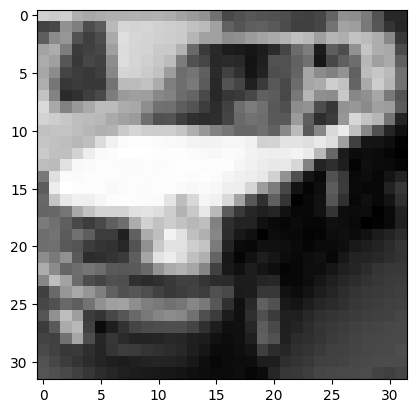

In [56]:
plt.imshow(cifar_binary[10][0][1, :, :], cmap = 'gray')

#### Convolutional Neural Network

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/790px-Typical_cnn.png)

#### Building the Convolutional Network

$$\text{INPUT} = (C_{in}, H_{in}, W_{in})$$

$$\text{OUTPUT} = (C_{out}, H_{out}, W_{out})$$

$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                    \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$

$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                    \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

In [57]:
#defining the network as a module
class CNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(16, 8, 3, padding = 1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)

    self.lin1 = nn.Linear(8*8*8, 64)
    self.act3 = nn.Tanh()
    self.lin2 = nn.Linear(64, 2)
  
  def forward(self, x):

    x = self.pool1(self.act1(self.conv1(x)))
    x = self.pool2(self.act2(self.conv2(x)))
    x = x.view(-1, 8*8*8) # flattening the feature maps
    x = self.act3(self.lin1(x))
    return self.lin2(x)

In [58]:
#model, optimizer, and loss
model = CNet()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
loss = nn.CrossEntropyLoss()

In [59]:
#model to gpu
model = model.to(device)

In [60]:
#train batches
train_loader = DataLoader(cifar_binary, batch_size = 32)

In [61]:
#train the model
training_loop(100, optimizer, model, loss, train_loader)

Epoch 1, Loss 161.3854289650917.
Epoch 100, Loss 4.434205505887803.


In [62]:
#validation loader
val_loader = DataLoader(cifar_binary_val, batch_size = 32, shuffle = False)

In [63]:
#validation function
def validate(model, train_loader, val_loader):
  for name, dataset in [("Train", train_loader), ("Test", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad():
      for imgs, labels in dataset:
        imgs = imgs.to(device)
        labels = labels.to(device)
        out = model(imgs)
        _, preds = torch.max(out, dim = 1)
        total += labels.shape[0]
        correct += int((preds == labels).sum())
      print(f"{name}: Accuracy: {correct/total}")

In [64]:
#examine the accuracy
validate(model, train_loader, val_loader)

Train: Accuracy: 0.9979
Test: Accuracy: 0.946


In [65]:
#save the model
torch.save(model.state_dict(), 'car_vs_plane.pt')

In [ ]:
#reload the model
reloaded = torch.load('car_vs_plane.pt')
reloaded

#### Problem

Load in the Digit Dataset from `pytorch`.

In [67]:
#download cifar10 as train
trainset = datasets.MNIST('.', download=True, train=True, transform=ToTensor())
valset = datasets.MNIST('.', download=True, train=False, transform=ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [70]:
class CNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 14, 1, padding = 1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(14, 7, 3, padding = 1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)

    self.lin1 = nn.Linear(7*7*7, 49)
    self.act3 = nn.Tanh()
    self.lin2 = nn.Linear(49, 2)
  
  def forward(self, x):

    x = self.pool1(self.act1(self.conv1(x)))
    x = self.pool2(self.act2(self.conv2(x)))
    x = x.view(-1, 7*7*7) # flattening the feature maps
    x = self.act3(self.lin1(x))
    return self.lin2(x)

In [71]:
training_loop(100, optimizer, model, loss, train_loader)

RuntimeError: ignored

#### Regularization

- Weight Decay
- Dropout

In [ ]:
def training_loop_l2(epochs, optimizer, model, loss_func, loader):
  for epoch in range(1, epochs + 1):
    loss_train = 0.0
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      outputs = model(x)
      loss = loss_func(outputs, y)
      ###lambda
      l2_lambda = 0.01
      ###compute the l2 term
      l2_norm = sum(param.pow(2).sum() for param in model.parameters())
      ###update loss
      loss = loss + l2_lambda*l2_norm
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      print(f'Epoch {epoch}, Loss {loss_train}.')

In [ ]:
class CNetDropout(nn.Module):
  def __init__(self, n_chans1 = 16):
    super.__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, 3, padding = 1)
    #add dropout
    self.conv1_dropout = nn.Dropout(.2)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, 3, padding = 1)
    #add dropout
    self.conv2_dropout = nn.Dropout(.2)
    self.lin1 = nn.Linear(8*8*n_chans1 // 2, 32)
    self.lin2 = nn.Linear(32, 2)

  def forward(self, x):
    x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    #use dropout
    x = self.conv1_dropout(x)
    x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
    #use dropout
    x = self.conv2_dropout(x)
    x = x.view(-1, 8*8*8*self.n_chans1 // 2)
    x = torch.tanh(self.lin1(x))
    x = self.lin2(x)
    return x 
